# Data Preparation

## Project: Write an Algorithm for Sentiment Analysis

---

In this notebook, ....



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a sentiment analysis dashboard.  At the end of this project, your code will accept any user-supplied text as input. 
As output you will get the expected category of your sentiment...



### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Visualysing data
* [Step 2](#step2): Pre processing data
* [Step 3](#step3): Analysing data
* [Step 4](#step4): Adapting pre processing for issue no serialization with custom transformers with mleap
* [Step 5](#step5): Tests

<a id='step0'></a>
## Step 0: Import Datasets

The dataset is available from [Sentiment140 dataset with 1.6 million tweets](https://www.kaggle.com/kazanova/sentiment140). This is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment . 
The target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive).

In [1]:
DATASET_ENCODING = "ISO-8859-1"
TEST_SIZE = 0.3
TRAIN_SIZE = 0.7
VAL_SIZE = 0.2
VOCABULARY_SIZE = 5000
DATA_DIR = 'data'
FEATURES_NUMBER = 50

In [2]:
from pyspark.ml import Pipeline
from pyspark.sql import *
from pyspark.sql.types import *
import pandas as pd
import numpy as np
import nltk
import pandas as pd
import os
import re

run this line if you are using sagemaker

In [3]:
#creating spark session in sagemaker
import sagemaker
from sagemaker import get_execution_role
import sagemaker_pyspark

role = get_execution_role()

# Configure Spark to use the SageMaker Spark dependency jars
jars = sagemaker_pyspark.classpath_jars()

classpath = ":".join(sagemaker_pyspark.classpath_jars())

# See the SageMaker Spark Github to learn how to connect to EMR from a notebook instance
spark = SparkSession.builder.config("spark.driver.extraClassPath", classpath)\
    .master("local[*]").getOrCreate()

Run this line if you are using the notebook in your computer

In [3]:
#creating spark session
spark = SparkSession.builder.appName('sentimentAnalysis').getOrCreate()

run this line if you are using sagemaker

In [4]:
#defining schema of the dataset
def get_schema_structure():
    
    #creating schema for dataset
    data_schema = [
        StructField("label", IntegerType(), True),
        StructField("ids", LongType(), True),
        StructField("date", StringType(), True),
        StructField("flag", StringType(), True),
        StructField("user", StringType(), True),
        StructField("text", StringType(), True)
    ]
    return StructType(fields=data_schema)

In [5]:
df = spark.read\
.schema(get_schema_structure())\
.format('csv')\
.option('encoding', DATASET_ENCODING)\
.option('header','false')\
.csv('s3a://sagemaker-us-east-2-446439287457/sagemaker/twitter/data/train.csv')\
.select('label', 'text')

In [6]:
df.printSchema()

root
 |-- label: integer (nullable = true)
 |-- text: string (nullable = true)



<a id='step1'></a>
## Step 1: Visualysing data

Convert df to pandas in order to visualize with matplotlib

In [6]:
df_pandas = df.toPandas()

In [8]:
df_pandas.head(5)

,label,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Text(0.5, 1.0, 'Dataset labels distribuition')

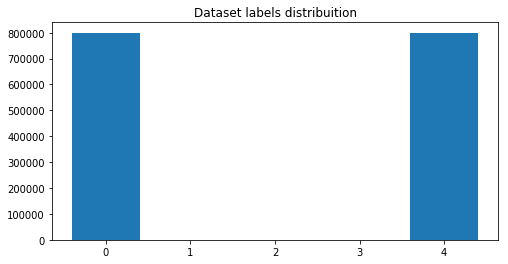

In [13]:
from collections import Counter
import matplotlib.pyplot as plt

target_cnt = Counter(df_pandas.label)

plt.figure(figsize=(8,4))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [14]:
!pip install wordcloud

In [9]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

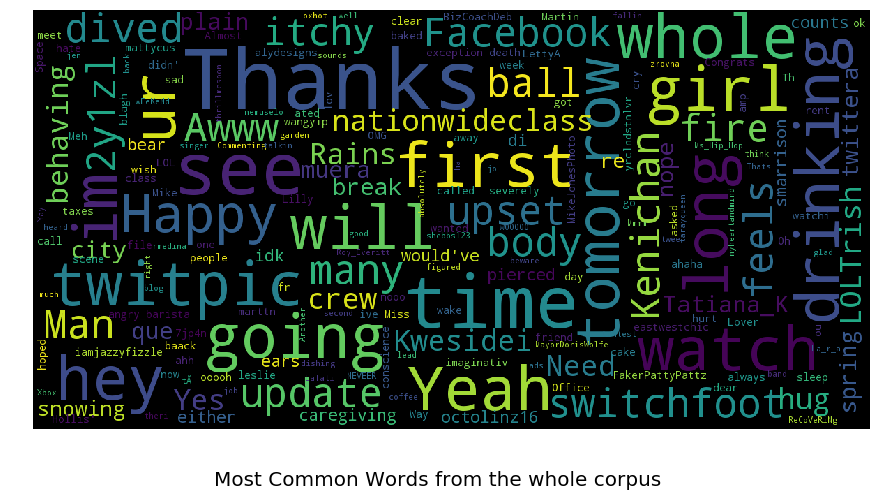

In [17]:
show_wordcloud(df_pandas['text'],'Most Common Words from the whole corpus')

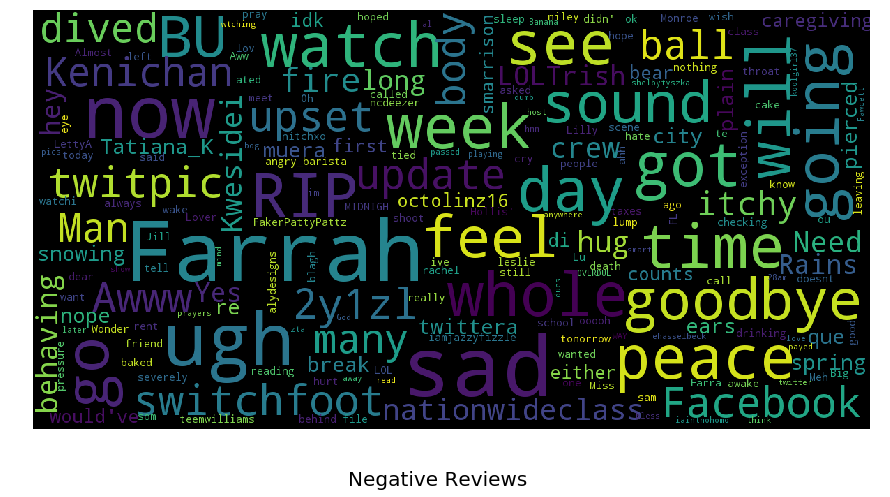

In [19]:
show_wordcloud(df_pandas[df_pandas['label'] == 0]['text'],'Negative Reviews')

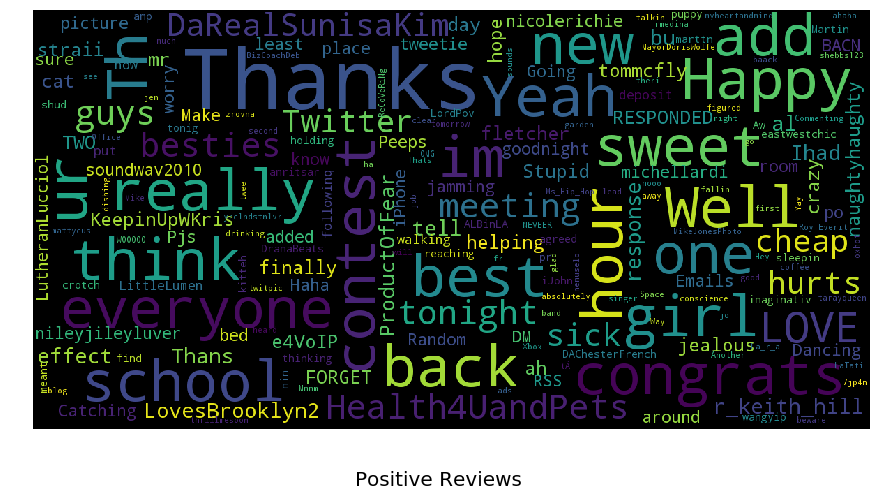

In [20]:
show_wordcloud(df_pandas[df_pandas['label'] == 4]['text'],'Positive Reviews')

In [21]:
%%time
# We are gonna find what emoticons are used in our dataset

tweets_text = df_pandas['text'].str.cat()
emos = set(re.findall(r" ([xX:;][-']?.) ",tweets_text))
emos_count = []
for emo in emos:
    emos_count.append((tweets_text.count(emo), emo))
sorted(emos_count,reverse=True)

CPU times: user 31.6 s, sys: 331 ms, total: 31.9 s
Wall time: 32.3 s


[(84244, '; '),
 (74505, ':/'),
 (38409, 'x '),
 (33938, ': '),
 (33934, 'xt'),
 (19885, 'xc'),
 (17623, 'xx'),
 (17517, 'xa'),
 (14163, ';3'),
 (13260, 'xi'),
 (12085, 'xp'),
 (11815, 'xo'),
 (9415, 'x@'),
 (7709, 'xe'),
 (7697, ';)'),
 (4458, ':3'),
 (3998, 'xy'),
 (3733, ';.'),
 (3484, 'xh'),
 (3458, 'x.'),
 (3448, 'X '),
 (3033, 'xD'),
 (2424, ';-'),
 (2343, ';t'),
 (2216, ';I'),
 (2167, ';s'),
 (2028, ':-'),
 (1961, 'xs'),
 (1937, ":'"),
 (1922, 'xb'),
 (1914, 'XD'),
 (1769, ':p'),
 (1719, ':O'),
 (1707, ':|'),
 (1665, ';D'),
 (1643, ':0'),
 (1586, 'x3'),
 (1516, 'xm'),
 (1470, 'Xx'),
 (1468, ":'("),
 (1448, 'x!'),
 (1448, ':S'),
 (1418, 'xI'),
 (1396, ';i'),
 (1356, ';@'),
 (1236, ';m'),
 (1231, 'x,'),
 (1183, '::'),
 (1165, 'xl'),
 (1160, ';p'),
 (1137, ':@'),
 (1123, ';-)'),
 (1076, ';a'),
 (1042, ':]'),
 (960, 'XO'),
 (950, ';d'),
 (916, 'xA'),
 (913, 'xf'),
 (876, ';P'),
 (863, 'XX'),
 (833, 'xd'),
 (798, ';L'),
 (797, 'xr'),
 (792, ';o'),
 (791, 'xX'),
 (773, ':L'),
 (747, '

In [22]:
HAPPY_EMO = r"([xX;:]-?[dD)]|:-?[\)]|[;:][pP])"
SAD_EMO = r"(:'?[/|\(])"
print("Happy emoticons:", set(re.findall(HAPPY_EMO, tweets_text)))
print("Sad emoticons:", set(re.findall(SAD_EMO, tweets_text)))

Happy emoticons: {'X)', 'XD', 'xD', ';-D', ';)', ':P', ':-d', 'x-d', ';d', ';p', 'x-)', ';D', 'x)', ':-D', 'Xd', 'x-D', ':d', ':)', 'X-D', ';-d', ':p', ';P', ':D', ';-)', 'xd'}
Sad emoticons: {":'/", ':(', ":'|", ':/', ":'(", ':|'}


In [29]:
%%time
from nltk.tokenize import word_tokenize
# Uncomment this line if you haven't downloaded punkt before
# or just run it as it is and uncomment it if you got an error.
#nltk.download('punkt')
def most_used_words(text):
    tokens = word_tokenize(text)
    frequency_dist = nltk.FreqDist(tokens)
    print("There is %d different words" % len(set(tokens)))
    return sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)

print(sorted(most_used_words(df_pandas['text'].str.cat())[:20]))

There is 1012643 different words
['!', "'s", ',', '.', '...', '?', '@', 'I', 'a', 'and', 'for', 'i', 'in', 'is', 'it', 'my', 'of', 'the', 'to', 'you']
CPU times: user 4min 9s, sys: 4.85 s, total: 4min 13s
Wall time: 4min 16s


<a id='step2'></a>
## Step 2: Pre processing data

Lots of fun and time here!!!

Labes have values from 0 to 1. Selecting column that will be used.

In [8]:
from pyspark.sql.functions import when

pre_split_df = df.withColumn("label",
              when(df["label"] == 4, 1).otherwise(df["label"])).select('label', 'text')

check how many positive and negative reviews are present in the dataset

splitting train and test data

In [9]:
train, test = pre_split_df.randomSplit([TRAIN_SIZE, TEST_SIZE], seed=2)

checking if the values for target are balanced

In [23]:
%%time

train.groupBy('label').count().show()

+-----+------+
|label| count|
+-----+------+
|    1|559849|
|    0|560279|
+-----+------+

CPU times: user 19.1 ms, sys: 15.4 ms, total: 34.5 ms
Wall time: 3min 26s


In [18]:
from transformers.PreProcessingGeneral import PreProcessingGeneral
from transformers.LemmatizeStemWords import LemmatizeStemWords
from transformers.NegateSequence import NegateSequence
from transformers.StopWordsCustom import StopWordsCustom
from pyspark.ml.feature import CountVectorizer, Tokenizer, NGram


# TODO add speling correction: Levenshtein Distance
pre_processing_general = PreProcessingGeneral(inputCol="text", outputCol="data_prep")
lemmatize_stem_stop_words = LemmatizeStemWords(inputCol="data_prep", outputCol="data_prep")
negate_sequence = NegateSequence(inputCol="data_prep", outputCol="data_prep")
stop_words_custom = StopWordsCustom(inputCol="data_prep", outputCol="data_prep")
ngram = NGram(n=2, inputCol="data_prep", outputCol="ngrams")
count_vectorizer = CountVectorizer(inputCol="ngrams", outputCol="features").setVocabSize(25000)

stages = [pre_processing_general, 
                              lemmatize_stem_stop_words, 
                              negate_sequence, 
                              stop_words_custom,
                              ngram,
                              count_vectorizer,
                             ]


stages_pipeline = Pipeline(stages = stages)


In [13]:
%%time
# Fit the pipeline to training documents.
data_prep = stages_pipeline.fit(train)

CPU times: user 63.9 ms, sys: 16.9 ms, total: 80.8 ms
Wall time: 5min 9s


In [20]:
#model = stages.model
from pyspark.ml.feature import CountVectorizerModel

vectorizers = [s for s in stages if isinstance(s, CountVectorizerModel)]

I wanted to check the vocabulary but I did not get it

In [ ]:
vectorizers

In [16]:
vocab = [v.vocabulary for v in vectorizers]

In [17]:
vocab

[]

So if you have a tip please let me know!!!!

In [10]:
%%time
# Fit the pipeline to training documents.
data_prep = stages_pipeline.fit(train)

CPU times: user 93.6 ms, sys: 31.6 ms, total: 125 ms
Wall time: 8min 46s


In [21]:
%%time

data_train = data_prep.transform(train)

CPU times: user 36.2 ms, sys: 6.86 ms, total: 43 ms
Wall time: 494 ms


write file in parquet format and save locally

In [22]:
%%time

data_train.write.parquet(os.path.join(DATA_DIR, 'train_n2_25000.parquet'))

CPU times: user 37.4 ms, sys: 20 ms, total: 57.3 ms
Wall time: 12min 43s


processing tests

In [23]:
%%time

data_test = data_prep.transform(test)

CPU times: user 40 ms, sys: 7.76 ms, total: 47.8 ms
Wall time: 185 ms


write test in a parquet file locally

In [24]:
%%time

data_test.write.parquet(os.path.join(DATA_DIR, 'test_n2_25000.parquet'))

CPU times: user 20.6 ms, sys: 13.4 ms, total: 33.9 ms
Wall time: 6min 17s


# Let's create the dataseet for the pipeline we will use for inference

Since mleap doesnt handle serialization of custom transformers, we will make some transformations before

In [7]:
#if you came directly from step 0 to here you should run the next 2 paragraphs
from pyspark.sql.functions import when

pre_split_df = df.withColumn("label",
              when(df["label"] == 4, 1).otherwise(df["label"])).select('label', 'text')

In [8]:
train, test = pre_split_df.randomSplit([TRAIN_SIZE, TEST_SIZE], seed=2)

In [9]:
#since we can not use custom transformers with mleap so the data will be processed 
#before sending to the ending point with the custom transformers
from transformers.PreProcessingGeneral import PreProcessingGeneral
from transformers.LemmatizeStemWords import LemmatizeStemWords
from transformers.NegateSequence import NegateSequence
from transformers.StopWordsCustom import StopWordsCustom
from transformers.PosProcessingGeneral import PosProcessingGeneral


# TODO add speling correction: Levenshtein Distance
pre_processing_general = PreProcessingGeneral(inputCol="text", outputCol="data_prep")
lemmatize_stem_stop_words = LemmatizeStemWords(inputCol="text", outputCol="data_prep")
negate_sequence = NegateSequence(inputCol="data_prep", outputCol="data_prep")
pos_processing = PosProcessingGeneral(inputCol="data_prep", outputCol="data_prep")


stages = [
    pre_processing_general,                               
    lemmatize_stem_stop_words,                              
    negate_sequence,
    pos_processing
]


stages_pipeline = Pipeline(stages = stages)

In [10]:
%%time
#import nltk
#nltk.download('wordnet')
# Fit the pipeline to training documents.
model = stages_pipeline.fit(train)

CPU times: user 203 µs, sys: 28 µs, total: 231 µs
Wall time: 220 µs


In [12]:
data_train = model.transform(train)
data_train.write.mode("overwrite").parquet('s3a://sagemaker-us-east-2-446439287457/sagemaker/twitter/data/processed/train.parquet')

[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
CPU times: user 373 ms, sys: 45.7 ms, total: 419 ms
Wall time: 7min 34s


In [14]:
%%time
data_test = model.transform(test)
data_test.write.mode("overwrite").parquet('s3a://sagemaker-us-east-2-446439287457/sagemaker/twitter/data/processed/test.parquet')

CPU times: user 129 ms, sys: 16 ms, total: 145 ms
Wall time: 12min 4s


<a id='step3'></a>
## Step 3: Analysing data

In [6]:
df_processed = spark.read.parquet(os.path.join(DATA_DIR, 'train.parquet'))

In [16]:
df_processed.show(10)

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|label|                text|           data_prep|              ngrams|          count_vect|            features|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|    0|                 ...|[miss, new, moon,...|[miss new, new mo...|(15000,[167,763,7...|(15000,[167,763,7...|
|    0|             i ju...|[want, hear, gues...|[want hear, hear ...|(15000,[3262,3565...|(15000,[3262,3565...|
|    0|          .. Omga...|[omgaga, im, sooo...|[omgaga im, im so...|(15000,[566,1990,...|(15000,[566,1990,...|
|    0|           FUCK YOU!|              [fuck]|                  []|       (15000,[],[])|       (15000,[],[])|
|    0|          i want ...|[want, benampjerr...|[want benampjerri...|       (15000,[],[])|       (15000,[],[])|
|    0|         i think ...|[think, mi, bf, c...|[think mi, mi bf,...|       (15000,[],[])|     

In [7]:
%%time

train_pandas = df_processed.select('label', 'data_prep', 'ngrams').toPandas()

CPU times: user 13.7 s, sys: 1.39 s, total: 15.1 s
Wall time: 30.5 s


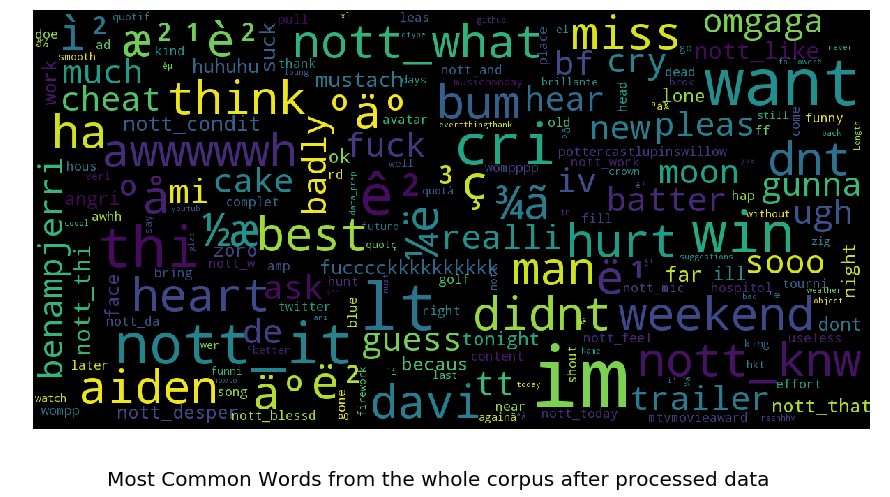

In [12]:
show_wordcloud(train_pandas['data_prep'],'Most Common Words from the whole corpus after processed data')

In [34]:
!pip install emoji --upgrade

Requirement already up-to-date: emoji in /Users/carolinaabs/anaconda/lib/python3.6/site-packages (0.5.4)


In [55]:
import emoji
print(emoji.emojize(' :monkey_face: the results could be better :neutral_face: '))

 🐵 the results could be better 😐 


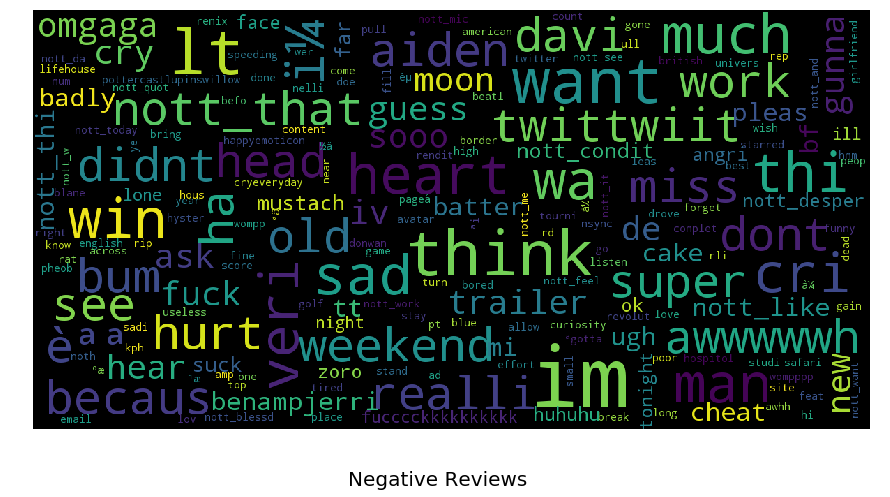

In [14]:
show_wordcloud(train_pandas[train_pandas['label'] == 0]['data_prep'],'Negative Reviews')

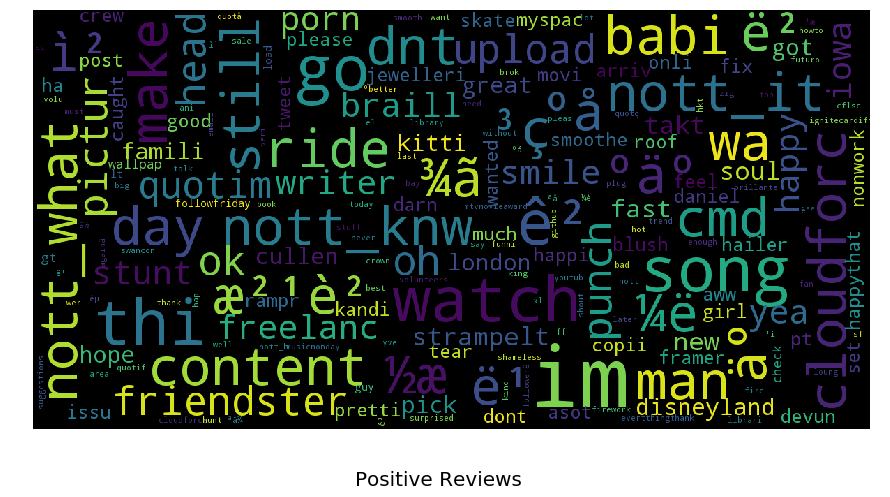

In [15]:
show_wordcloud(train_pandas[train_pandas['label'] == 1]['data_prep'],'Positive Reviews')

In [32]:
%%time

print(sorted(most_used_words(train_pandas['data_prep'].apply(', '.join).str.cat())[:20]))

There is 974394 different words
['!', ',', 'cant', 'day', 'get', 'go', 'good', 'got', 'im', 'it', 'like', 'love', 'no', 'not', 'nott_the', 'nott_to', 'thi', 'time', 'wa', 'work']
CPU times: user 1min 18s, sys: 1.74 s, total: 1min 20s
Wall time: 1min 21s


<a id='step4'></a>
## Step 4:Adapting pre processing for issue no serialization with custom transformers with mleap
 It does not seem a trivial task to serialize custom transformers with pyspark so we have to prepare the data before sending to the pipeline that wil be used for inference.

## Test

### Test cells

Let's start by testing out your code.

In [5]:
from pyspark.sql import Row

# Create dataframe for tests
'''creates a dataset for tests'''
r1 = Row(0, 123, 'Monday 2019', '@test', 'carocat', "34 1/3 studying I don't want b !!!!")
r2 = Row(0, 123, 'Monday 2019', '@test', 'carocat', 'need need need Deep learning is so difficult :(')
r3 = Row(1, 123, 'Monday 2019', '@test', 'carocat', ':-) spaaaaaaa is horrible')
r4 = Row(1, 123, 'Monday 2019', '@test', 'carocat', ':-) Spark is sad')

row_Seq = [r1, r2, r3, r4]
dframe = spark.createDataFrame(row_Seq, get_schema_structure())

In [24]:
from pyspark.sql import Row

# Create dataframe for tests
'''creates a dataset for tests'''
r1 = Row(0, 123, 'Monday 2019', '@test', 'carocat', "studying I don't want b !")
r2 = Row(0, 123, 'Monday 2019', '@test', 'carocat', 'ned dep learning is so dificult sademoticons')
r3 = Row(1, 123, 'Monday 2019', '@test', 'carocat', 'happyemoticons spa is horible')
r4 = Row(1, 123, 'Monday 2019', '@test', 'carocat', 'happyemoticons spark is sad')

row_Seq = [r1, r2, r3, r4]
dframe = spark.createDataFrame(row_Seq, get_schema_structure())

In [26]:
from transformers.PreProcessingGeneral import PreProcessingGeneral
pre_processing_general = PreProcessingGeneral(inputCol="text", outputCol="data_prep")
from pyspark.sql.functions import udf
dpre = pre_processing_general.transform(dframe)

from pandas.testing import assert_frame_equal

In [27]:
import pandas as pd
dpre.toPandas().head()

,label,ids,date,flag,user,text,data_prep
0,0,123,Monday 2019,@test,carocat,34 1/3 studying I don't want b !!!!,studying I don't want b !
1,0,123,Monday 2019,@test,carocat,need need need Deep learning is so difficult :(,ned Dep learning is so dificult sademoticons
2,1,123,Monday 2019,@test,carocat,:-) spaaaaaaa is horrible,happyemoticons spa is horible
3,1,123,Monday 2019,@test,carocat,:-) Spark is sad,happyemoticons Spark is sad
